In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Input block of 2x2 pixels
# p0 p1
# p2 p3
# Forward 2D Haar transformation
# b0 = (p0 + p1) + (p2 + p3) 'DC level
# b1 = (p0 - p1) + (p2 - p3) 'Horizontal difference
# b2 = (p0 + p1) - (p2 + p3) 'Vertical difference
# b3 = (p0 - p1) - (p2 - p3) 'Horizontal and vertical difference

In [10]:
# test reshape dimension

block = np.arange(9)
print(block)
block = block.reshape((3,3))
print(block)

block= block.reshape(9)
print(block)

[0 1 2 3 4 5 6 7 8]
[[0 1 2]
 [3 4 5]
 [6 7 8]]
[0 1 2 3 4 5 6 7 8]


In [5]:
# neighborhood construction revisit:

from tensorflow.keras.datasets import cifar10
# ---------- Load MNIST data and split ----------
(x_train, y_train), (x_test,y_test) = cifar10.load_data()
# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')
x_test = np.asarray(x_test,dtype='float32')
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')
print("training with input:", x_train.shape)



training with input: (50000, 32, 32, 3)


(1, 32, 32, 3)


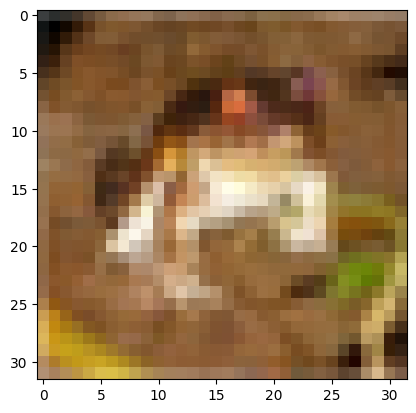

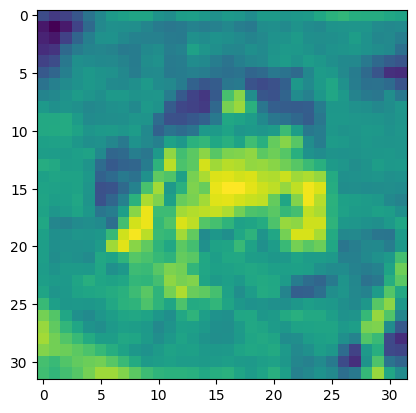

In [19]:
imgtest = x_train[:1,:,:,:]
print(imgtest.shape)
# print(imgtest[0].shape)
plt.imshow(imgtest[0]/255)
plt.show()

plt.imshow(imgtest[0,:,:,0])
plt.show()

(1, 2, 2, 3, 1, 16, 16, 1)
0 0 0


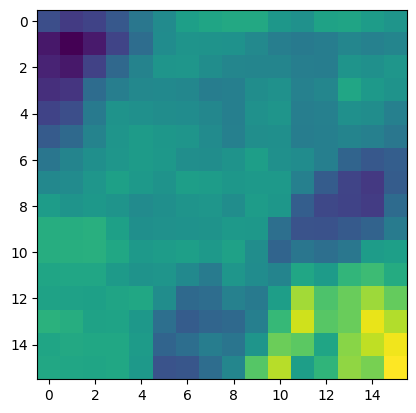

0 0 1


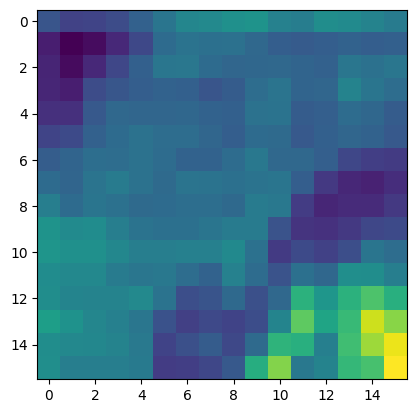

0 0 2


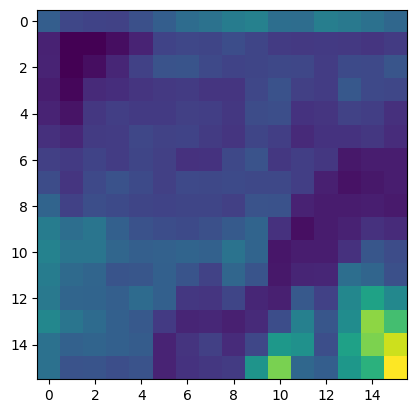

0 1 0


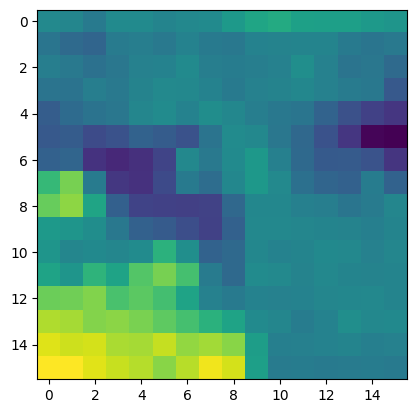

0 1 1


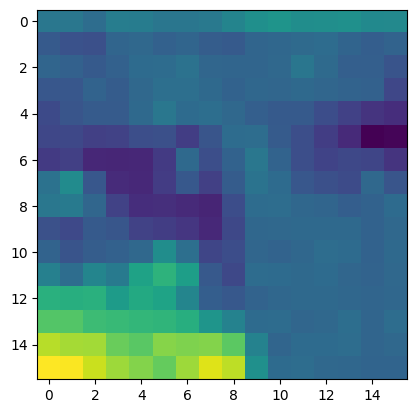

0 1 2


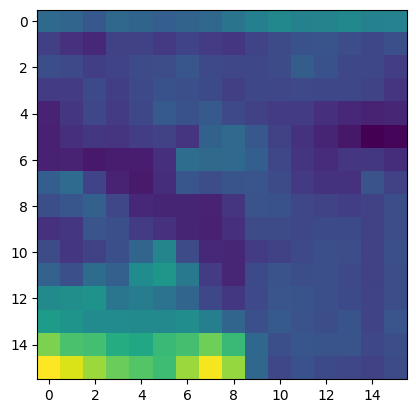

1 0 0


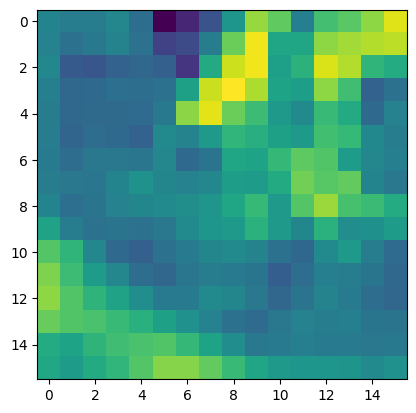

1 0 1


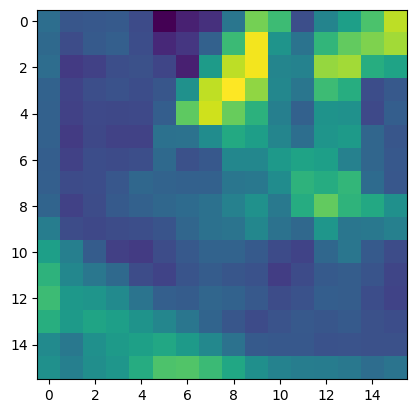

1 0 2


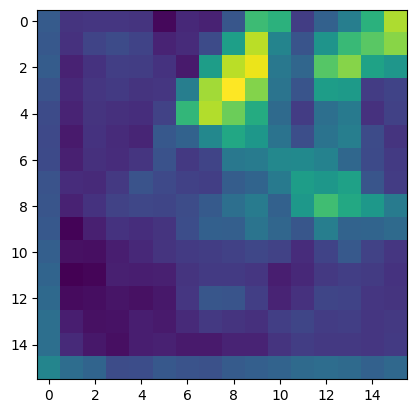

1 1 0


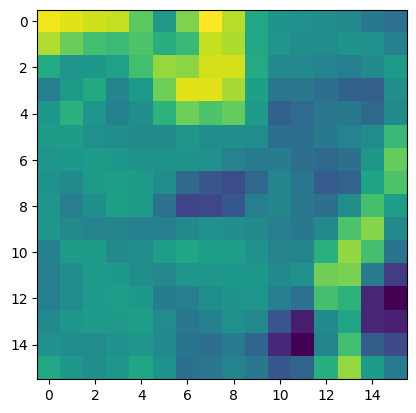

1 1 1


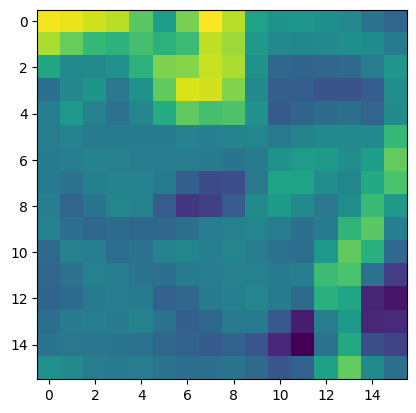

1 1 2


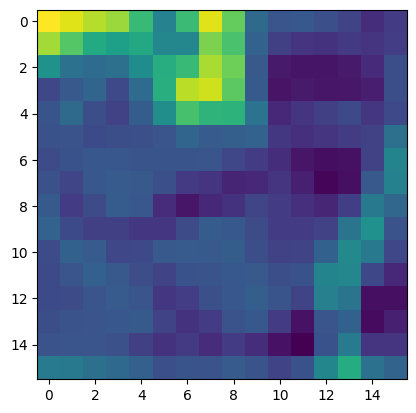

In [22]:
from skimage.util import view_as_windows

win = 16
x = view_as_windows(imgtest, (1, win, win, 1), (1, win, win, 1))
print(x.shape)
S = x.shape
for i in range(S[1]):
    for j in range(S[2]):
        for k in range(S[3]):
            
            print(i, j, k)
            wintest = x[0,i,j,k]
            # print(wintest.shape)
            plt.imshow(wintest[0])
            plt.show()

In [30]:
# 2D haar transform:

win = 2
stride = 1
X = view_as_windows(imgtest, (1, win, win, 1), (1, stride, stride, 1))
print(X.shape)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3],-1)
print(X.shape)


(1, 31, 31, 3, 1, 2, 2, 1)
(1, 31, 31, 3, 4)


In [31]:
# p0 p1
# p2 p3
# Forward 2D Haar transformation


p0 = X[:,:,:,:,0]
p1 = X[:,:,:,:,1]
p2 = X[:,:,:,:,2]
p3 = X[:,:,:,:,3]

b0 = (p0 + p1) + (p2 + p3) #DC level
b1 = (p0 - p1) + (p2 - p3) #'Horizontal difference
b2 = (p0 + p1) - (p2 + p3) #'Vertical difference
b3 = (p0 - p1) - (p2 - p3) #'Horizontal and vertical difference

print(b0.shape)

(1, 31, 31, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


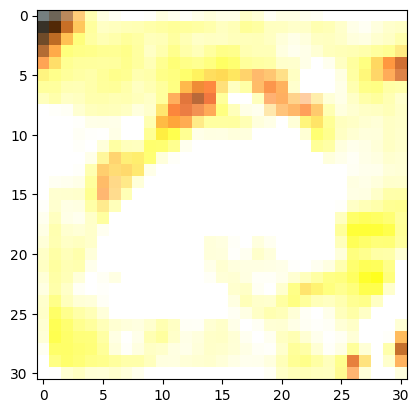

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


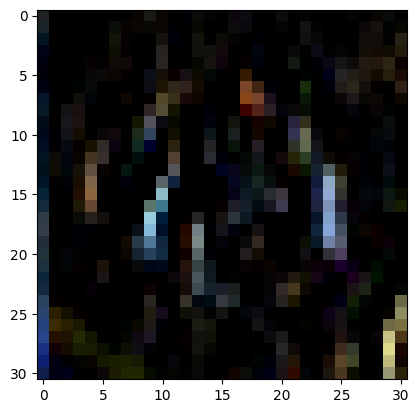

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


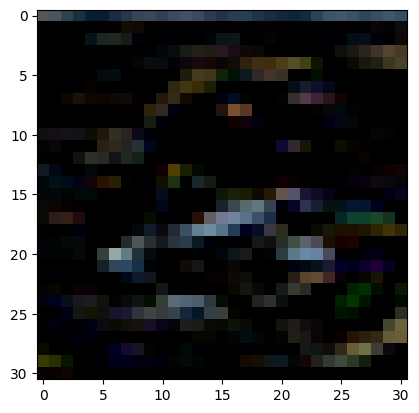

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


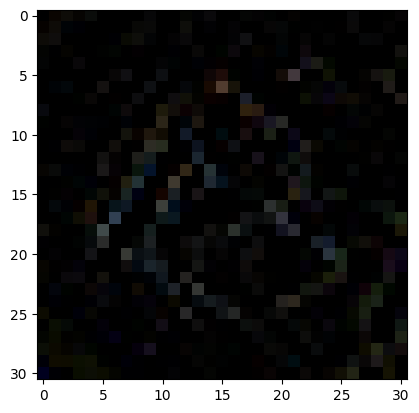

In [34]:
plt.imshow(b0[0]/256)
plt.show()

plt.imshow(b1[0]/256)
plt.show()

plt.imshow(b2[0]/256)
plt.show()

plt.imshow(b3[0]/256)
plt.show()

In [36]:
channeltmp = np.concatenate((b0, b1, b2, b3), axis = -1 )
print(channeltmp.shape)

(1, 31, 31, 12)


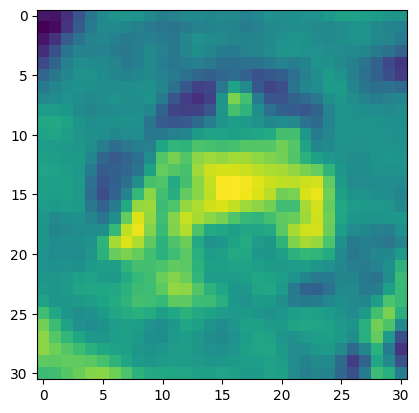

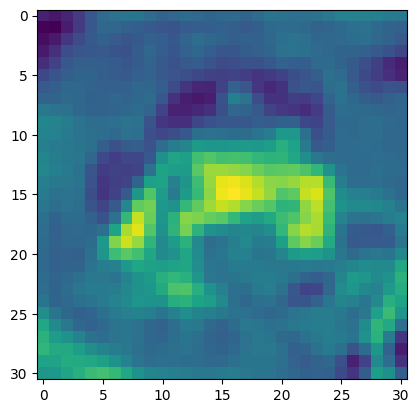

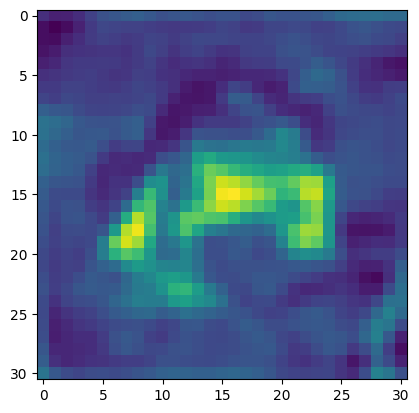

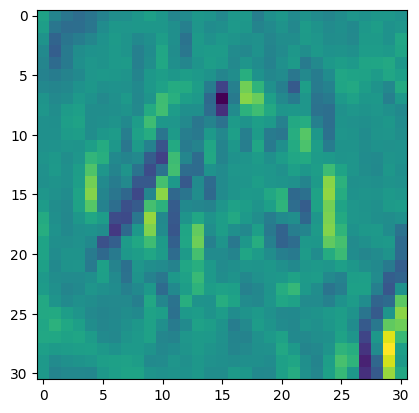

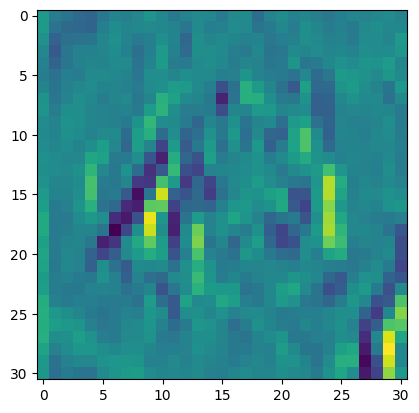

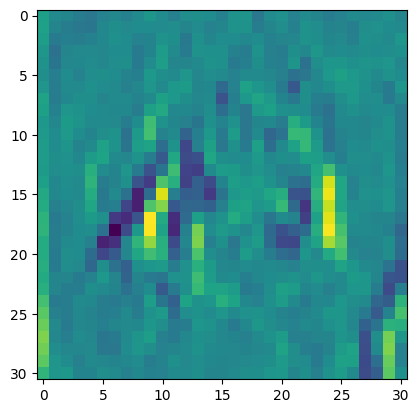

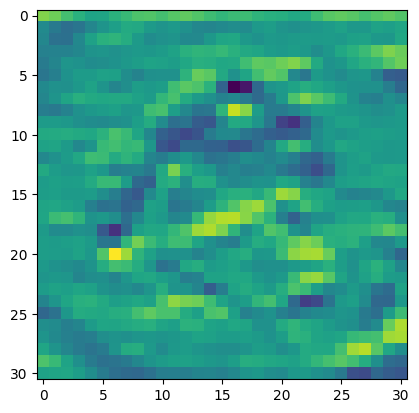

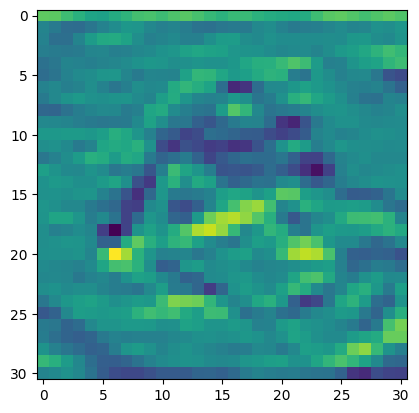

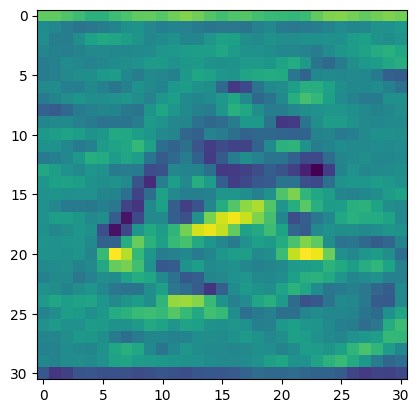

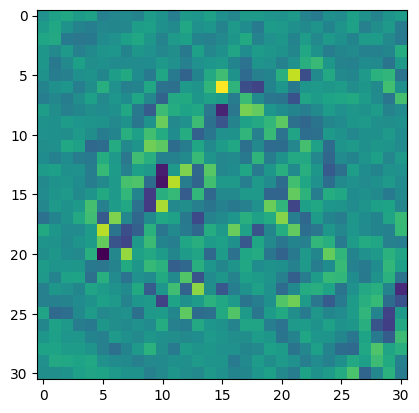

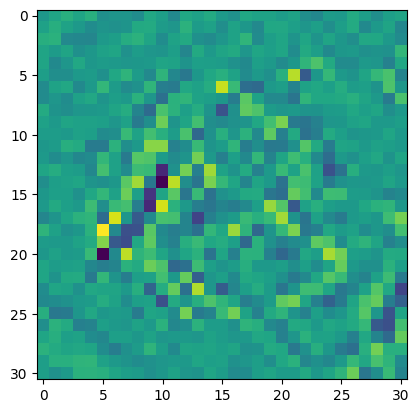

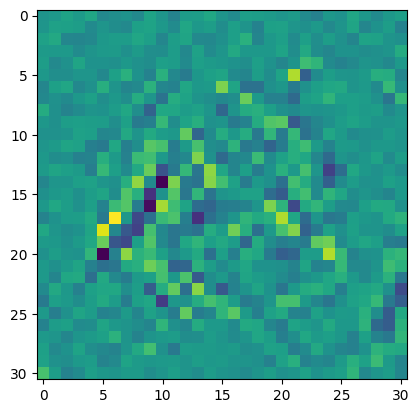

In [37]:
for i in range(12):
    
    plt.imshow(channeltmp[0,:,:,i])
    plt.show()

In [38]:
from skimage.measure import block_reduce

def MaxPooling(x,step=2):
    if len(x.shape)<4:
        return block_reduce(x, (1, step, step), np.max)
    else:
        return block_reduce(x, (1, step, step, 1), np.max)

In [39]:
pooltmp = MaxPooling(channeltmp)
print(pooltmp.shape)

(1, 16, 16, 12)


In [61]:
def HAAR_Transform(Xinput, steps = 1):

    featuremaps = []
    featmap = Xinput
    curstep = 0
    while curstep < steps:
        
        print("_____________in step :", curstep, '_______________')
        print("input feature map:", featmap.shape)
        curstep += 1
        win = 2
        stride = 1
        X = view_as_windows(featmap, (1, win, win, 1), (1, stride, stride, 1))
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3],-1)
        
        print("shape for HAAR input:", X.shape)
        p0 = X[:,:,:,:,0]
        p1 = X[:,:,:,:,1]
        p2 = X[:,:,:,:,2]
        p3 = X[:,:,:,:,3]

        b0 = (p0 + p1) + (p2 + p3) #DC level
        b1 = (p0 - p1) + (p2 - p3) #'Horizontal difference
        b2 = (p0 + p1) - (p2 + p3) #'Vertical difference
        b3 = (p0 - p1) - (p2 - p3) #'Horizontal and vertical difference
        
        feattmp = np.concatenate((b0, b1, b2, b3), axis = -1 )
        feattmp = MaxPooling(feattmp)
        print("feature map shape for current step:", feattmp.shape)
        featuremaps.append(feattmp)
        
        featmap = feattmp[:,:,:,:3]
    
    return featuremaps
        

In [62]:
test = HAAR_Transform(x_train[:1], 4)

for featmap in test:
    
    print(featmap.shape)

_____________in step : 0 _______________
input feature map: (1, 32, 32, 3)
shape for HAAR input: (1, 31, 31, 3, 4)
feature map shape for current step: (1, 16, 16, 12)
_____________in step : 1 _______________
input feature map: (1, 16, 16, 3)
shape for HAAR input: (1, 15, 15, 3, 4)
feature map shape for current step: (1, 8, 8, 12)
_____________in step : 2 _______________
input feature map: (1, 8, 8, 3)
shape for HAAR input: (1, 7, 7, 3, 4)
feature map shape for current step: (1, 4, 4, 12)
_____________in step : 3 _______________
input feature map: (1, 4, 4, 3)
shape for HAAR input: (1, 3, 3, 3, 4)
feature map shape for current step: (1, 2, 2, 12)
(1, 16, 16, 12)
(1, 8, 8, 12)
(1, 4, 4, 12)
(1, 2, 2, 12)


In [51]:
# test each feature maps:
# visualization
for idx, featmap in enumerate(test):
    
    # print("in featmap:", idx)
    print(featmap.shape)
    for i in range(featmap.shape[-1]):
        
        # print('channel:', i)
        plt.imshow(featmap[0,:,:,i])
        # plt.show()
        plt.savefig('./results/hopidx_' + str(idx) + "_channel_" + str(i) + '.jpg')
        plt.close()

in featmap: 0
(50000, 16, 16, 12)
channel: 0
channel: 1
channel: 2
channel: 3
channel: 4
channel: 5
channel: 6
channel: 7
channel: 8
channel: 9
channel: 10
channel: 11
in featmap: 1
(50000, 8, 8, 12)
channel: 0
channel: 1
channel: 2
channel: 3
channel: 4
channel: 5
channel: 6
channel: 7
channel: 8
channel: 9
channel: 10
channel: 11
in featmap: 2
(50000, 4, 4, 12)
channel: 0
channel: 1
channel: 2
channel: 3
channel: 4
channel: 5
channel: 6
channel: 7
channel: 8
channel: 9
channel: 10
channel: 11
in featmap: 3
(50000, 2, 2, 12)
channel: 0
channel: 1
channel: 2
channel: 3
channel: 4
channel: 5
channel: 6
channel: 7
channel: 8
channel: 9
channel: 10
channel: 11


In [58]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn
import cv2
Xtrain = []
for img in x_train:
    
    imgflip = cv2.flip(img,1)
    Xtrain.append(imgflip)
    
Xtrain = np.array(Xtrain)
print(Xtrain.shape)

Xtrain = np.concatenate((Xtrain,x_train),axis=0)
print(Xtrain.shape)

Ytrain = np.concatenate((y_train,y_train),axis=0)

feattrain = HAAR_Transform(Xtrain, 4)
feattest = HAAR_Transform(x_test, 4)

print("train feats:")
for feat in feattrain:
    
    print(feat.shape)
    
print("test feats:")
for feat in feattest:
    
    print(feat.shape)

(50000, 32, 32, 3)
(100000, 32, 32, 3)
_____________in step : 4 _______________
input feature map: (100000, 32, 32, 3)
shape for HAAR input: (100000, 31, 31, 3, 4)
feature map shape for current step: (100000, 16, 16, 12)
_____________in step : 3 _______________
input feature map: (100000, 16, 16, 3)
shape for HAAR input: (100000, 15, 15, 3, 4)
feature map shape for current step: (100000, 8, 8, 12)
_____________in step : 2 _______________
input feature map: (100000, 8, 8, 3)
shape for HAAR input: (100000, 7, 7, 3, 4)
feature map shape for current step: (100000, 4, 4, 12)
_____________in step : 1 _______________
input feature map: (100000, 4, 4, 3)
shape for HAAR input: (100000, 3, 3, 3, 4)
feature map shape for current step: (100000, 2, 2, 12)
_____________in step : 4 _______________
input feature map: (10000, 32, 32, 3)
shape for HAAR input: (10000, 31, 31, 3, 4)
feature map shape for current step: (10000, 16, 16, 12)
_____________in step : 3 _______________
input feature map: (10000, 

In [63]:
hopidx = 0

trainmap = feattrain[hopidx]
testmap = feattest[hopidx]

trainmap = trainmap.reshape(trainmap.shape[0], -1)
testmap = testmap.reshape(testmap.shape[0], -1)

print(trainmap.shape, testmap.shape)

(100000, 3072) (10000, 3072)


In [64]:
from sklearn.model_selection import train_test_split

X_fit, X_val, y_fit, y_val = train_test_split(
    trainmap, Ytrain, test_size=0.01, random_state=42)

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

train data: (99000, 3072) (99000, 1)
val data: (1000, 3072) (1000, 1)


train data: (99000, 3072) (99000, 1)
val data: (1000, 3072) (1000, 1)


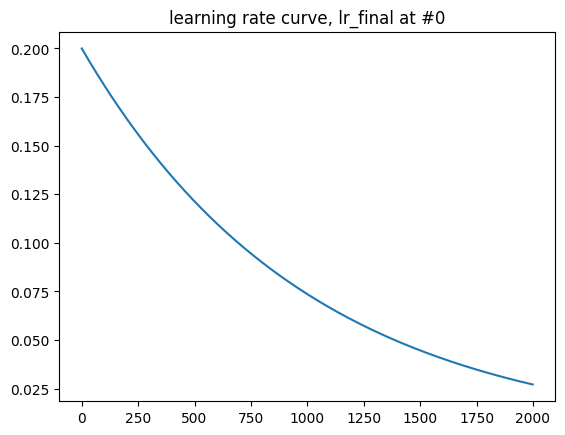

/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[100]	fit's multi_logloss: 0.532205	val's multi_logloss: 1.04704


In [66]:
import lightgbm as lgb
import math
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn
import time

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

fit = lgb.Dataset(
    X_fit, y_fit,
)

val = lgb.Dataset(
    X_val, y_val,
)

maxdepth = 5
lr0 = 0.2 # make sure GD at the begining
lr_final = 0.2 # make sure final converge faster
k = -0.001 # lower -> more smooth
num_rounds = 2000
rounds = np.arange(num_rounds)
rounds_lr = lr0 * math.e**(k * rounds)
plt.plot(rounds, rounds_lr)
plt.title("learning rate curve, lr_final at #" + str(int(math.log(lr_final/lr0)/k)) )
plt.show()

evals_result = {} 

t0 = time.time()
model = lgb.train(
    params={
        'learning_rate': 0.1,
        'max_depth': maxdepth,
        # 'num_leaves': 10,
        'device' : 'gpu',
        # 'gpu_platform_id' : 0,
        # 'gpu_device_id' : 0 ,
        # 'num_gpu' : 2,
        'objective': 'multiclass',
        'num_class':10,
        # 'feature_fraction': 0.4,
        # 'bagging_fraction': 0.6,
        # 'bagging_freq': 10,
        'verbose' : -1
           },
    train_set=fit,
    num_boost_round=num_rounds,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    # early_stopping_rounds=200,
    evals_result=evals_result,
    verbose_eval=100,
    # fobj=fl.lgb_obj,
    # feval=fl.lgb_eval,
    callbacks=[lgb.reset_parameter(learning_rate=lambda \
        current_round: max(lr0 * math.e**(k * current_round), lr_final))]
)

print("training time:", time.time()-t0)
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

plt.plot(evals_result['val']['multi_logloss'])
plt.show()

y_preds =model.predict(X_fit)
y_train_preds = []
for x in y_preds:
    y_train_preds.append(np.argmax(x))

y_train_preds = np.array(y_train_preds)

train_accuracy = accuracy_score(y_fit, y_train_preds)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))


In [ ]:
# process feature map:

# feat1:

